# 01_data_extraction_pipeline.ipynb

In [1]:
import os
import random
import shutil
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from mimetypes import guess_type

# For downloading from Google Drive
import gdown


In [2]:
# Setup paths

from pathlib import Path
import os
import random
import shutil
from tqdm import tqdm
import glob

ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data" / "raw"
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"

# Create folders
for path in [TRAIN_DIR, TEST_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print("Folder structure ready:", DATA_DIR)

Folder structure ready: ..\data\raw


In [3]:
import gdown

# Home Assignment URL
drive_url = "https://drive.google.com/drive/folders/1smMAVwDrBAzt01ynQ0J8QJjG37fGz92P"

# download the entire folder into DATA_DIR
!gdown --folder "{drive_url}" -O "{DATA_DIR}" --quiet

print("Download complete! Files saved to:", DATA_DIR)

Download complete! Files saved to: ..\data\raw


In [4]:
from PyPDF2 import PdfReader, PdfWriter
import os
from pathlib import Path
from tqdm import tqdm
import glob

# Step 1: Split multi-page PDFs safely
pdf_files = glob.glob(str(DATA_DIR / "**/*.pdf"), recursive=True)

split_count = 0

for pdf_path in tqdm(pdf_files, desc="Checking and splitting PDFs"):
    try:
        with open(pdf_path, "rb") as infile:  # ensures file is closed afterward
            reader = PdfReader(infile)
            num_pages = len(reader.pages)

            if num_pages > 1:
                base_name = Path(pdf_path).stem
                parent_dir = Path(pdf_path).parent

                for i, page in enumerate(reader.pages, start=1):
                    writer = PdfWriter()
                    writer.add_page(page)
                    new_name = parent_dir / f"{base_name}-page{i}.pdf"
                    with open(new_name, "wb") as out_f:
                        writer.write(out_f)

                split_count += 1

        # So safe to delete original
        if num_pages > 1:
            os.remove(pdf_path)

    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")

print(f"Multi-page PDFs split successfully! ({split_count} files were split)")


Checking and splitting PDFs: 100%|██████████| 32/32 [00:00<00:00, 74.16it/s]

Multi-page PDFs split successfully! (6 files were split)


In [5]:
# Collect all files (PDFs, images, etc.)
all_files = glob.glob(str(DATA_DIR / "**/*"), recursive=True)
all_files = [f for f in all_files if os.path.isfile(f)]

# Pick a random subset for testing
random.seed(42)
test_files = random.sample(all_files, min(10, len(all_files)))

# Move selected files to TEST_DIR
for f in tqdm(test_files, desc="Moving test files"):
    dest = TEST_DIR / Path(f).name
    shutil.move(f, dest)

print("Moved", len(test_files), "files to test folder.")

Moving test files: 100%|██████████| 10/10 [00:00<00:00, 793.41it/s]

Moved 10 files to test folder.


In [6]:
# Move remaining files to TRAIN_DIR
for f in tqdm(all_files, desc="Moving remaining files to train"):
    if f not in test_files:  # skip ones already moved
        dest = TRAIN_DIR / Path(f).name
        shutil.move(f, dest)

print("✅ Training files moved:", len(list(TRAIN_DIR.glob('**/*'))))


Moving remaining files to train: 100%|██████████| 48/48 [00:00<00:00, 2245.44it/s]

✅ Training files moved: 38


In [7]:
import pandas as pd
from mimetypes import guess_type
import os

train_files = [f for f in TRAIN_DIR.glob("**/*") if f.is_file()]

metadata = []
for f in train_files:
    mime, _ = guess_type(f)
    ext = f.suffix.lower().replace('.', '') if f.suffix else 'none'
    metadata.append({
        "file_path": str(f),
        "file_name": f.name,
        "extension": ext,
        "mime_type": mime or "unknown",
        "size_kb": round(os.path.getsize(f) / 1024, 2)
    })

df_meta = pd.DataFrame(metadata)

print(f"Metadata collected for {len(df_meta)} files")
df_meta.head()


Metadata collected for 38 files


,file_path,file_name,extension,mime_type,size_kb
0,..\data\raw\train\Copy of ARPFIINVOEBTCHLASER ...,Copy of ARPFIINVOEBTCHLASER (1).pdf,pdf,application/pdf,38.43
1,..\data\raw\train\Copy of ARPFIINVOEBTCHLASER ...,Copy of ARPFIINVOEBTCHLASER (10)-page2.pdf,pdf,application/pdf,37.44
2,..\data\raw\train\Copy of ARPFIINVOEBTCHLASER ...,Copy of ARPFIINVOEBTCHLASER (10)-page3.pdf,pdf,application/pdf,37.50
3,..\data\raw\train\Copy of ARPFIINVOEBTCHLASER ...,Copy of ARPFIINVOEBTCHLASER (10)-page4.pdf,pdf,application/pdf,37.54
4,..\data\raw\train\Copy of ARPFIINVOEBTCHLASER ...,Copy of ARPFIINVOEBTCHLASER (12).pdf,pdf,application/pdf,38.25


In [8]:
# Summary Statistics
if not df_meta.empty:
    total_files = len(df_meta)
    pdf_count = (df_meta['extension'] == 'pdf').sum()
    pdf_percent = (pdf_count / total_files) * 100

    print(f"Total files in train set: {total_files}")
    print(f"PDF files: {pdf_count} ({pdf_percent:.2f}%)")
    print(f"Other formats: {total_files - pdf_count}")

else:
    print("No files found in train folder.")


Total files in train set: 38
PDF files: 38 (100.00%)
Other formats: 0


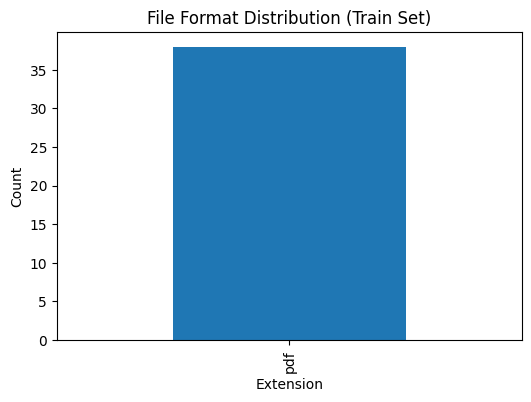

Train set: 38 files | Test set: 10 files


In [9]:
# Visual Overview
import matplotlib.pyplot as plt

df_meta['extension'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("File Format Distribution (Train Set)")
plt.xlabel("Extension")
plt.ylabel("Count")
plt.show()

print(f"Train set: {len(train_files)} files | Test set: {len(os.listdir(TEST_DIR))} files")


# Data Augmentation Summary
During data preparation, we observed that all files provided in the dataset were in PDF format, while the original task specification expected both PDF and image formats. To align the dataset with this expectation, we performed a simple augmentation step.

For each of the training and testing folders, 50% of the available PDF files were randomly selected (using a fixed random seed for reproducibility). Each selected PDF was then converted into an image representation by rendering the first page as a JPG file. These JPG files were saved in the same directories alongside their original PDF counterparts.

This approach allowed us to maintain the original PDF files while also introducing corresponding image files (e.g., abc.pdf → abc.jpg) to simulate the mixed-format dataset described in the task requirements.

In [10]:
import fitz 
import random
from pathlib import Path
from tqdm import tqdm


random.seed(42)

from pathlib import Path
ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data" / "raw"
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"


def convert_pdf_to_jpg(pdf_path, output_path):
    """Convert the first page of a PDF to JPG."""
    try:
        with fitz.open(pdf_path) as pdf:
            page = pdf.load_page(0)  # first page only
            pix = page.get_pixmap(dpi=600)
            pix.save(output_path)
    except Exception as e:
        print(f" Error converting {pdf_path.name}: {e}")

def augment_with_jpgs(folder):
    pdf_files = list(Path(folder).glob("*.pdf"))
    if not pdf_files:
        print(f" No PDF files found in {folder}")
        return

    n_to_convert = len(pdf_files) // 2
    selected_pdfs = random.sample(pdf_files, n_to_convert)

    for pdf_path in tqdm(selected_pdfs, desc=f"Converting PDFs in {folder.name}"):
        jpg_path = pdf_path.with_suffix(".jpg")
        convert_pdf_to_jpg(pdf_path, jpg_path)

    print(f" Converted {len(selected_pdfs)} PDFs to JPGs in {folder.name}")


augment_with_jpgs(TRAIN_DIR)
augment_with_jpgs(TEST_DIR)


train_jpgs = list(TRAIN_DIR.glob("*.jpg"))
test_jpgs = list(TEST_DIR.glob("*.jpg"))
print(f"\n Total JPGs created: {len(train_jpgs)} (train) + {len(test_jpgs)} (test)")


Converting PDFs in train: 100%|██████████| 19/19 [00:32<00:00,  1.69s/it]


 Converted 19 PDFs to JPGs in train


Converting PDFs in test: 100%|██████████| 5/5 [00:08<00:00,  1.72s/it]

 Converted 5 PDFs to JPGs in test

 Total JPGs created: 19 (train) + 5 (test)


In [13]:
import pandas as pd
from mimetypes import guess_type
import os

train_files = [f for f in TRAIN_DIR.glob("**/*") if f.is_file()]

metadata = []
for f in train_files:
    mime, _ = guess_type(f)
    ext = f.suffix.lower().replace('.', '') if f.suffix else 'none'
    metadata.append({
        "file_path": str(f),
        "file_name": f.name,
        "extension": ext,
        "mime_type": mime or "unknown",
        "size_kb": round(os.path.getsize(f) / 1024, 2)
    })

df_meta = pd.DataFrame(metadata)

print(f"Metadata collected for {len(df_meta)} files")

Metadata collected for 57 files


In [14]:
# Summary Statistics
if not df_meta.empty:
    total_files = len(df_meta)
    pdf_count = (df_meta['extension'] == 'pdf').sum()
    pdf_percent = (pdf_count / total_files) * 100

    print(f"Total files in train set: {total_files}")
    print(f"PDF files: {pdf_count} ({pdf_percent:.2f}%)")
    print(f"Other formats: {total_files - pdf_count}")

else:
    print("No files found in train folder.")

Total files in train set: 57
PDF files: 38 (66.67%)
Other formats: 19


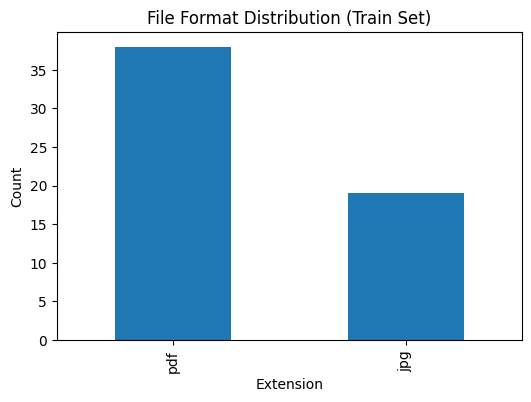

Train set: 57 files | Test set: 15 files


In [15]:
# Visual Overview
import matplotlib.pyplot as plt

df_meta['extension'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("File Format Distribution (Train Set)")
plt.xlabel("Extension")
plt.ylabel("Count")
plt.show()

print(f"Train set: {len(train_files)} files | Test set: {len(os.listdir(TEST_DIR))} files")


# Why I’m Using EasyOCR

I’m using EasyOCR instead of PaddleOCR or an NLP-based OCR because it’s lightweight and uses fewer resources. Since we’ll use an LLM for text correction in a later step, high OCR precision isn’t critical at this stage. EasyOCR gives good enough results while keeping processing simple and efficient.

In [16]:
# Purpose: I provide two clear extraction paths:
#   1) ExtractTextFromPDF(pdf_path) - try native PDF text extraction first.
#      If the native text is meaningful (>= 10 chars), I persist it to data/raw/extracted_texts.csv.
#      If not, I fall back to ExtractTextFromImageNamed(pdf_path).
#   2) ExtractTextFromImageNamed(path) - normalize input to PNG(s) and run EasyOCR.
#      It returns (normalized_path_or_aggregate_path, extracted_text).
#
# Use:
#   text, status = ExtractTextFromPDF("path/to/file.pdf")
#   - status is "native" if native layer used, "image" if OCR fallback used.
#   - on failure (no meaningful text after image OCR) I raise ValueError.

from pathlib import Path
from pdf2image import convert_from_path
from PIL import Image
import fitz  # PyMuPDF
import os
from tqdm import tqdm
import tempfile
import csv
import statistics
from typing import Tuple, Optional, List, Any
import shutil
import easyocr

# Initialize EasyOCR model globally (English only by default)
ocr_model = easyocr.Reader(['en'], gpu=False)

# CSV storage path
RAW_CSV = Path("..") / "data" / "raw" / "extracted_texts.csv"
TRAIN_DIR = Path("..") / "data" / "raw" / "train"

# Minimum confidence threshold. If OCR returns a numeric confidence and it's below this,
# a ValueError is raised so you can see the failing file.
MIN_CONFIDENCE = 0.50

Using CPU. Note: This module is much faster with a GPU.


In [17]:
import cv2
from PIL import Image, ImageEnhance

def preprocess_image_for_ocr(img_path: Path) -> Path:
    """Enhance brightness, contrast, and sharpness for better OCR."""
    img = Image.open(img_path).convert("L")  # Grayscale

    # 1. Increase brightness & contrast slightly
    img = ImageEnhance.Brightness(img).enhance(1.2)
    img = ImageEnhance.Contrast(img).enhance(1.5)

    # 2. Sharpen
    img = ImageEnhance.Sharpness(img).enhance(2.0)

    # 3. Convert to OpenCV format for thresholding
    cv_img = np.array(img)
    _, thresh = cv2.threshold(cv_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 4. Save cleaned version
    clean_path = img_path.with_name(img_path.stem + "_clean.png")
    cv2.imwrite(str(clean_path), thresh)

    return clean_path


In [18]:
def _ensure_raw_csv_exists(csv_path: Path) -> None:
    """
    I ensure the data/raw directory and CSV exist. If the CSV doesn't exist,
    I create it with the two-column header expected by downstream steps.
    """
    print("called extract ensure", csv_path)

    csv_path.parent.mkdir(parents=True, exist_ok=True)
    if not csv_path.exists():
        with csv_path.open("w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(["file_path", "extracted_text"])

In [19]:
def _append_to_raw_csv(csv_path: Path, file_path: str, extracted_text: str) -> None:
    """
    I append a single row to the CSV. I escape newlines to keep each CSV row one logical line.
    """
    print("called extract append", csv_path)

    _ensure_raw_csv_exists(csv_path)
    normalized_text = extracted_text.replace("\r\n", "\n").replace("\n", "\\n")
    with csv_path.open("a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([file_path, normalized_text])

In [20]:
from typing import Any, Tuple, Optional, List
import statistics

def _parse_easyocr_result_for_text_and_conf(raw_result: Any) -> Tuple[str, Optional[float]]:
    """
    Parse EasyOCR output to return (combined_text, mean_confidence_or_None).

    EasyOCR returns a list like:
        [
          [ [x1, y1], [x2, y2], [x3, y3], [x4, y4] ], "text", confidence
        ]

    This function extracts all text and computes the average confidence.
    """
    lines: List[str] = []
    confidences: List[float] = []

    # Safety check
    if not raw_result:
        return "", None

    # Handle standard EasyOCR list-of-lists output
    if isinstance(raw_result, (list, tuple)):
        for item in raw_result:
            # Each item typically: [bbox, text, confidence]
            try:
                if isinstance(item, (list, tuple)) and len(item) >= 3:
                    text = item[1]
                    conf = item[2]
                    if isinstance(text, str):
                        cleaned_text = text.strip()
                        if cleaned_text:
                            lines.append(cleaned_text)
                    try:
                        confidences.append(float(conf))
                    except Exception:
                        pass
                elif isinstance(item, (list, tuple)) and len(item) == 2:
                    # Handle rare case [text, conf]
                    text, conf = item
                    lines.append(str(text).strip())
                    try:
                        confidences.append(float(conf))
                    except Exception:
                        pass
                elif isinstance(item, dict):
                    # Some versions of EasyOCR might return a dict (less common)
                    text = item.get("text") or item.get("string")
                    conf = item.get("confidence") or item.get("score")
                    if text:
                        lines.append(str(text).strip())
                    if conf is not None:
                        try:
                            confidences.append(float(conf))
                        except Exception:
                            pass
                else:
                    # Fallback: raw string or unknown type
                    if isinstance(item, str):
                        lines.append(item.strip())
            except Exception:
                continue

    # Combine all detected lines
    cleaned_lines = [" ".join(l.split()) for l in lines if l]
    final_text = "\n".join(cleaned_lines).strip()

    # Compute mean confidence
    mean_conf = None
    if confidences:
        try:
            mean_conf = float(statistics.mean(confidences))
        except Exception:
            mean_conf = None

    return final_text, mean_conf


In [21]:
import tempfile
import statistics
from pathlib import Path
from typing import Tuple, Optional, List
import shutil
from pdf2image import convert_from_path
from PIL import Image

def ExtractTextFromImageNamed(path: str) -> Tuple[str, str, Optional[float]]:
    """
    Accepts either an image path or a PDF path.
    - If PDF: rasterize pages into temporary PNGs and OCR each page.
    - If image: normalize into ../data/raw/temp and OCR that PNG.
    After OCR completes, the temp folder (../data/raw/temp) is removed.
    Returns: (representative_path, extracted_text, mean_confidence_or_None)
    Also appends extracted_text to CSV so image results are logged.
    """

    input_path = Path(path)
    print("called extract image", input_path)
    if not input_path.exists():
        raise FileNotFoundError(f"Input path not found: {path}")

    aggregated_text_chunks: List[str] = []
    page_confs: List[float] = []
    representative_path = str(input_path)

    tmp_folder = Path("..") / "data" / "raw" / "temp"
    tmp_created = False

    try:
        # --- PDF branch ---
        if input_path.suffix.lower() == ".pdf":
            with tempfile.TemporaryDirectory() as tmpdir:
                try:
                    pages = convert_from_path(str(input_path), dpi=300)
                except Exception as e:
                    raise RuntimeError(f"Failed to rasterize PDF '{path}': {e}")

                for i, pil_page in enumerate(pages):
                    page_png = Path(tmpdir) / f"page_{i+1}.png"
                    pil_page.convert("RGB").save(page_png, "PNG")

                    try:
                        raw_results = ocr_model.readtext(str(page_png))
                    except Exception as e:
                        raise RuntimeError(f"EasyOCR failed on PDF page {i+1} of '{path}': {e}")

                    page_text, page_conf = _parse_easyocr_result_for_text_and_conf(raw_results)

                    if not page_text:
                        raise RuntimeError(f"No text found by OCR on PDF page {i+1} of '{path}'")

                    aggregated_text_chunks.append(page_text)
                    if page_conf is not None:
                        page_confs.append(page_conf)

                representative_path = f"{str(input_path)}::pages-{len(pages)}"

        # --- Image branch ---
        else:
            if not tmp_folder.exists():
                tmp_folder.mkdir(parents=True, exist_ok=True)
                tmp_created = True

            try:
                with Image.open(input_path) as im:
                    im_rgb = im.convert("RGB")
                    normalized_path = tmp_folder / f"{input_path.stem}.normalized.png"
                    im_rgb.save(normalized_path, "PNG")
                    representative_path = str(normalized_path)
            except Exception as e:
                raise RuntimeError(f"Failed to create normalized PNG for '{path}': {e}")

            try:
                clean_path = preprocess_image_for_ocr(normalized_path)
            except Exception as e:
                print(f"Warning: Preprocessing failed for '{normalized_path}', using raw image. Error: {e}")
                clean_path = normalized_path



            try:
                ocr_results = ocr_model.readtext(str(normalized_path))
            except Exception as e:
                raise RuntimeError(f"EasyOCR failed on image '{path}': {e}")

            page_text, page_conf = _parse_easyocr_result_for_text_and_conf(ocr_results)

            if not page_text:
                raise RuntimeError(f"No text found by OCR on image '{path}'")

            if page_conf is not None and page_conf < MIN_CONFIDENCE:
                print(f"Confidence score = {page_conf:.4f} for image '{path}'")
                raise ValueError(f"Low OCR confidence ({page_conf:.4f}) for image '{path}'")

            aggregated_text_chunks.append(page_text)
            if page_conf is not None:
                page_confs.append(page_conf)

        # --- Aggregate results ---
        extracted_text = "\n".join([chunk for chunk in aggregated_text_chunks if chunk]).strip()

        aggregate_conf: Optional[float] = None
        if page_confs:
            try:
                aggregate_conf = float(statistics.mean(page_confs))
            except Exception:
                aggregate_conf = None

        _append_to_raw_csv(RAW_CSV, str(input_path), extracted_text)

        return representative_path, extracted_text, aggregate_conf

    finally:
        try:
            if tmp_created and tmp_folder.exists():
                shutil.rmtree(tmp_folder)
                print(f"Temporary folder deleted: {tmp_folder}")
        except Exception as e:
            print(f"Failed to cleanup temp folder {tmp_folder}: {e}")


In [22]:
def _is_text_meaningful(text: str, min_chars: int) -> bool:
    """
    I use a simple length check to decide whether the text is meaningful.
    This is intentionally simple; I can replace it later with token counts,
    invoice token heuristics, or alphabetic-character checks.

    Note:
      The threshold (min_chars) is declared internally as a Final constant `can`
      to emphasize that it should not be modified within the function.
    """
    min_chars = 10
    if not text:
        return False
    return len(text.strip()) >= min_chars

In [23]:
import fitz  # PyMuPDF
from pathlib import Path
from typing import Tuple

def ExtractTextFromPDF(pdf_path: str) -> Tuple[str, str]:
    """
    Extract text from a PDF using a two-step strategy:

      1. Try native PDF text extraction via PyMuPDF (fast & low-resource).
      2. If native text is too short or empty, fallback to image-based OCR
         via EasyOCR (through ExtractTextFromImageNamed()).

    Returns:
        (extracted_text, status)
        where status ∈ {"native", "image"}.

    Raises:
        FileNotFoundError: if path doesn’t exist.
        ValueError: if neither native nor OCR yields meaningful text.
    """

    pdf_file = Path(pdf_path)
    if not pdf_file.exists():
        raise FileNotFoundError(f"Input file not found: {pdf_path}")

    PDF_TEXT_MIN_CHARS = 10

    # Step 1: Try native text extraction
    native_text_parts = []
    try:
        with fitz.open(str(pdf_file)) as doc:
            for page in doc:
                text = page.get_text("text") or ""
                native_text_parts.append(text)
    except Exception as e:
        print(f"[WARN] Native extraction failed for {pdf_path}: {e}")
        native_text_parts = []

    native_text = "\n".join(native_text_parts).strip()

    # Step 2: Check if native extraction is meaningful
    if _is_text_meaningful(native_text, PDF_TEXT_MIN_CHARS):
        _append_to_raw_csv(RAW_CSV, str(pdf_file), native_text)
        return native_text, "native"

    # Step 3: Fallback to OCR (EasyOCR)
    try:
        rep_path, ocr_text, conf = ExtractTextFromImageNamed(str(pdf_file))
    except Exception as e:
        raise RuntimeError(f"EasyOCR fallback failed for {pdf_path}: {e}")

    # Step 4: Check OCR result
    if _is_text_meaningful(ocr_text, PDF_TEXT_MIN_CHARS):
        _append_to_raw_csv(RAW_CSV, str(pdf_file), ocr_text)
        return ocr_text, "image"

    # Step 5: If still empty, raise error
    raise ValueError(f"No meaningful text extracted from {pdf_path} after native + OCR fallback.")


In [27]:
import pandas as pd
import traceback
from pathlib import Path
import numpy as np

def process_raw_data_folder():
    """
    Walk ../data/raw/train and process items.
    - If extension is .pdf -> use ExtractTextFromPDF
    - Else -> assume it's an image and use ExtractTextFromImageNamed
    """
    target_dir = Path("../data/raw/train").resolve()
    if not target_dir.exists():
        raise FileNotFoundError(f"Directory not found: {target_dir}")

    def is_candidate_file(p: Path) -> bool:
        if not p.is_file():
            return False
        if any(part.startswith(".") for part in p.relative_to(target_dir).parts):
            return False
        if p.name == RAW_CSV.name:
            return False
        return True

    files = sorted([f for f in target_dir.iterdir() if is_candidate_file(f)])
    print(f"Discovered {len(files)} candidate files in {target_dir}")
    if files:
        for f in files[:50]:
            print("  -", f.name)

    for f in files:
        try:
            ext = f.suffix.lower()
            print(f"\nProcessing: {f.name} (ext={ext})")

            if ext == ".pdf":
                # --- PDF branch ---
                print(f"[PDF DETECTED] {f.name}")
                text, status = ExtractTextFromPDF(str(f))
                print(f"PDF processed -> status: {status}, length={len(text or '')}")
            
            else:
                # --- Image branch ---
                print(f"[IMAGE DETECTED] {f.name}")
                rep, text, conf = ExtractTextFromImageNamed(str(f))
                print(f"Image processed -> conf={conf}, text length={len(text or '')}")

            # After successful extraction, verify CSV presence
            if RAW_CSV.exists():
                df = pd.read_csv(RAW_CSV)
                print(f"CSV rows: {len(df)}")
            else:
                print("CSV file does not exist after processing!")

        except Exception as e:
            print(f"\n Error processing file: {f.name}")
            traceback.print_exc()

    # --- CSV summary at end ---
    if RAW_CSV.exists():
        df = pd.read_csv(RAW_CSV)
        print("\n CSV Preview (last 5 rows):")
        print(df.tail())
    else:
        print("CSV file does not exist yet.")


In [28]:
def cleanup_temp_folder() -> None:
    """
    Deletes the ../data/raw/temp folder and all its contents.
    Safe to call at the end of a run.
    """
    temp_dir = Path("..") / "data" / "raw" / "temp"
    if temp_dir.exists():
        shutil.rmtree(temp_dir)
        print(f"Temporary folder deleted: {temp_dir}")
    else:
        print(f"No temp folder found to delete at: {temp_dir}")


In [30]:
import traceback

try:
    print("Starting data extraction.\n")
    process_raw_data_folder()
except Exception as e:
    print("\nTop-level error during process_raw_data_folder():", repr(e))
    print("Traceback:")
    traceback.print_exc()
finally:
    print("\nCleaning up temporary folders...")
    try:
        cleanup_temp_folder()
        print("Temp folder cleanup completed.")
    except Exception as cleanup_err:
        print("Failed during cleanup:", repr(cleanup_err))
        traceback.print_exc()

print("\nAll done.")

Starting data extraction.

Discovered 57 candidate files in C:\Stealth AI\Clean Reader\data\raw\train
  - Copy of ARPFIINVOEBTCHLASER (1).jpg
  - Copy of ARPFIINVOEBTCHLASER (1).pdf
  - Copy of ARPFIINVOEBTCHLASER (10)-page2.jpg
  - Copy of ARPFIINVOEBTCHLASER (10)-page2.pdf
  - Copy of ARPFIINVOEBTCHLASER (10)-page3.jpg
  - Copy of ARPFIINVOEBTCHLASER (10)-page3.pdf
  - Copy of ARPFIINVOEBTCHLASER (10)-page4.pdf
  - Copy of ARPFIINVOEBTCHLASER (12).pdf
  - Copy of ARPFIINVOEBTCHLASER (13).pdf
  - Copy of ARPFIINVOEBTCHLASER (14).jpg
  - Copy of ARPFIINVOEBTCHLASER (14).pdf
  - Copy of ARPFIINVOEBTCHLASER (2).jpg
  - Copy of ARPFIINVOEBTCHLASER (2).pdf
  - Copy of ARPFIINVOEBTCHLASER (3).jpg
  - Copy of ARPFIINVOEBTCHLASER (3).pdf
  - Copy of ARPFIINVOEBTCHLASER (4)-page3.pdf
  - Copy of ARPFIINVOEBTCHLASER (5).pdf
  - Copy of ARPFIINVOEBTCHLASER (6)-page1.pdf
  - Copy of ARPFIINVOEBTCHLASER (6)-page2.pdf
  - Copy of ARPFIINVOEBTCHLASER (7).jpg
  - Copy of ARPFIINVOEBTCHLASER (7).pdf
 

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9169371963916279, text length=1438
CSV rows: 1

Processing: Copy of ARPFIINVOEBTCHLASER (1).pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (1).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=1430
CSV rows: 2

Processing: Copy of ARPFIINVOEBTCHLASER (10)-page2.jpg (ext=.jpg)
[IMAGE DETECTED] Copy of ARPFIINVOEBTCHLASER (10)-page2.jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of ARPFIINVOEBTCHLASER (10)-page2.jpg


c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9215294516081862, text length=908
CSV rows: 3

Processing: Copy of ARPFIINVOEBTCHLASER (10)-page2.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (10)-page2.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=905
CSV rows: 4

Processing: Copy of ARPFIINVOEBTCHLASER (10)-page3.jpg (ext=.jpg)
[IMAGE DETECTED] Copy of ARPFIINVOEBTCHLASER (10)-page3.jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of ARPFIINVOEBTCHLASER (10)-page3.jpg


c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9259067930506586, text length=949
CSV rows: 5

Processing: Copy of ARPFIINVOEBTCHLASER (10)-page3.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (10)-page3.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=950
CSV rows: 6

Processing: Copy of ARPFIINVOEBTCHLASER (10)-page4.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (10)-page4.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=989
CSV rows: 7

Processing: Copy of ARPFIINVOEBTCHLASER (12).pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (12).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\ra

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9122376957985957, text length=1108
CSV rows: 10

Processing: Copy of ARPFIINVOEBTCHLASER (14).pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (14).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=1110
CSV rows: 11

Processing: Copy of ARPFIINVOEBTCHLASER (2).jpg (ext=.jpg)
[IMAGE DETECTED] Copy of ARPFIINVOEBTCHLASER (2).jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of ARPFIINVOEBTCHLASER (2).jpg


c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.909559113791621, text length=1395
CSV rows: 12

Processing: Copy of ARPFIINVOEBTCHLASER (2).pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (2).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=1389
CSV rows: 13

Processing: Copy of ARPFIINVOEBTCHLASER (3).jpg (ext=.jpg)
[IMAGE DETECTED] Copy of ARPFIINVOEBTCHLASER (3).jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of ARPFIINVOEBTCHLASER (3).jpg


c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9095499773848461, text length=1367
CSV rows: 14

Processing: Copy of ARPFIINVOEBTCHLASER (3).pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (3).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=1363
CSV rows: 15

Processing: Copy of ARPFIINVOEBTCHLASER (4)-page3.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (4)-page3.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=954
CSV rows: 16

Processing: Copy of ARPFIINVOEBTCHLASER (5).pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (5).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_t

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9118171155512198, text length=1203
CSV rows: 20

Processing: Copy of ARPFIINVOEBTCHLASER (7).pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (7).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=1201
CSV rows: 21

Processing: Copy of ARPFIINVOEBTCHLASER (8)-page1.jpg (ext=.jpg)
[IMAGE DETECTED] Copy of ARPFIINVOEBTCHLASER (8)-page1.jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of ARPFIINVOEBTCHLASER (8)-page1.jpg


c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9053250981506487, text length=1404
CSV rows: 22

Processing: Copy of ARPFIINVOEBTCHLASER (8)-page1.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (8)-page1.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=1398
CSV rows: 23

Processing: Copy of ARPFIINVOEBTCHLASER (8)-page2.jpg (ext=.jpg)
[IMAGE DETECTED] Copy of ARPFIINVOEBTCHLASER (8)-page2.jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of ARPFIINVOEBTCHLASER (8)-page2.jpg


c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9196404262523917, text length=966
CSV rows: 24

Processing: Copy of ARPFIINVOEBTCHLASER (8)-page2.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (8)-page2.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=967
CSV rows: 25

Processing: Copy of ARPFIINVOEBTCHLASER (8)-page3.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (8)-page3.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=955
CSV rows: 26

Processing: Copy of ARPFIINVOEBTCHLASER (8)-page4.jpg (ext=.jpg)
[IMAGE DETECTED] Copy of ARPFIINVOEBTCHLASER (8)-page4.jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of ARPF

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9084629604710706, text length=969
CSV rows: 27

Processing: Copy of ARPFIINVOEBTCHLASER (8)-page4.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (8)-page4.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=967
CSV rows: 28

Processing: Copy of ARPFIINVOEBTCHLASER (9)-page1.jpg (ext=.jpg)
[IMAGE DETECTED] Copy of ARPFIINVOEBTCHLASER (9)-page1.jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of ARPFIINVOEBTCHLASER (9)-page1.jpg


c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9053250981506487, text length=1404
CSV rows: 29

Processing: Copy of ARPFIINVOEBTCHLASER (9)-page1.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (9)-page1.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=1398
CSV rows: 30

Processing: Copy of ARPFIINVOEBTCHLASER (9)-page2.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (9)-page2.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=967
CSV rows: 31

Processing: Copy of ARPFIINVOEBTCHLASER (9)-page3.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (9)-page3.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9084629604710706, text length=969
CSV rows: 33

Processing: Copy of ARPFIINVOEBTCHLASER (9)-page4.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER (9)-page4.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=967
CSV rows: 34

Processing: Copy of ARPFIINVOEBTCHLASER.pdf (ext=.pdf)
[PDF DETECTED] Copy of ARPFIINVOEBTCHLASER.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=1206
CSV rows: 35

Processing: Copy of Inv_20065629_from_Franks_Quality_Produce_18417572_22492.jpg (ext=.jpg)
[IMAGE DETECTED] Copy of Inv_20065629_from_Franks_Quality_Produce_18417572_22492.jpg
called extract image C:\Stealth AI\Clean R

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9216309822648071, text length=677
CSV rows: 36

Processing: Copy of Inv_20065629_from_Franks_Quality_Produce_18417572_22492.pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20065629_from_Franks_Quality_Produce_18417572_22492.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=692
CSV rows: 37

Processing: Copy of Inv_20066901_from_Franks_Quality_Produce_18471648_18416.pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20066901_from_Franks_Quality_Produce_18471648_18416.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=679
CSV rows: 38

Processing: Copy of Inv_20068140_from_Franks_Quality_Produce_18529019_11828.pdf (ext=.pdf)
[PDF

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.8992384131864248, text length=655
CSV rows: 40

Processing: Copy of Inv_20071084_from_Franks_Quality_Produce_18665028_7884.pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20071084_from_Franks_Quality_Produce_18665028_7884.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=670
CSV rows: 41

Processing: Copy of Inv_20072265_from_Franks_Quality_Produce_18697771_15688.pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20072265_from_Franks_Quality_Produce_18697771_15688.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=668
CSV rows: 42

Processing: Copy of Inv_20072898_from_Franks_Quality_Produce_18731344_15688.jpg (ext=.jpg)
[IMAGE

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9156271283772384, text length=693
CSV rows: 43

Processing: Copy of Inv_20072898_from_Franks_Quality_Produce_18731344_15688.pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20072898_from_Franks_Quality_Produce_18731344_15688.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=711
CSV rows: 44

Processing: Copy of Inv_20074433_from_Franks_Quality_Produce_18802791_20408 (1).pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20074433_from_Franks_Quality_Produce_18802791_20408 (1).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=630
CSV rows: 45

Processing: Copy of Inv_20074433_from_Franks_Quality_Produce_18802791_20408.pdf (ext=.p

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9162322156285027, text length=622
CSV rows: 47

Processing: Copy of Inv_20075310_from_Franks_Quality_Produce_18842235_13952.pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20075310_from_Franks_Quality_Produce_18842235_13952.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=637
CSV rows: 48

Processing: Copy of Inv_20076301_from_Franks_Quality_Produce_18887473_13748 (1).pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20076301_from_Franks_Quality_Produce_18887473_13748 (1).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=678
CSV rows: 49

Processing: Copy of Inv_20076301_from_Franks_Quality_Produce_18887473_13748.pdf (ext=.p

c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9054339802952568, text length=693
CSV rows: 52

Processing: Copy of Inv_20077622_from_Franks_Quality_Produce_18946409_7596.pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20077622_from_Franks_Quality_Produce_18946409_7596.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=711
CSV rows: 53

Processing: Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132 (1).jpg (ext=.jpg)
[IMAGE DETECTED] Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132 (1).jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132 (1).jpg


c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9182463467559283, text length=593
CSV rows: 54

Processing: Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132 (1).pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132 (1).pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=606
CSV rows: 55

Processing: Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132.jpg (ext=.jpg)
[IMAGE DETECTED] Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132.jpg
called extract image C:\Stealth AI\Clean Reader\data\raw\train\Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132.jpg


c:\Stealth AI\Clean Reader\.env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
Temporary folder deleted: ..\data\raw\temp
Image processed -> conf=0.9182463467559283, text length=593
CSV rows: 56

Processing: Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132.pdf (ext=.pdf)
[PDF DETECTED] Copy of Inv_20078834_from_Franks_Quality_Produce_18994615_32132.pdf
called extract append ..\data\raw\extracted_texts.csv
called extract ensure ..\data\raw\extracted_texts.csv
PDF processed -> status: native, length=606
CSV rows: 57

 CSV Preview (last 5 rows):
                                            file_path  \
52  C:\Stealth AI\Clean Reader\data\raw\train\Copy...   
53  C:\Stealth AI\Clean Reader\data\raw\train\Copy...   
54  C:\Stealth AI\Clean Reader\data\raw\train\Copy...   
55  C:\Stealth AI\Clean Reader\data\raw\train\Copy...   
56  C:\Stealth AI\Clean Reader\data\raw\train\Copy...   

                                       extracted_text  
52  Invo

# Regex cleaning

In [ ]:
"""
Reads:  ../data/raw/extracted_texts.csv
Writes: ../data/processed/regex_cleaned_invoices.csv

Output columns (in this order):
  file_path, id, invoice_number, vendor, date, total, line_items_count, cleaned_text

Notes:
 - cleaned_text is the cleaned version of the original extracted_text (escape sequences,
   phone/fax/order-desk tokens removed, reduced whitespace, boilerplate removed).
 - Vendor extraction favors website (www.x.com) or email (user@domain.com). If not found,
   it will fallback to the topmost non-empty line of the cleaned text.
 - This version also removes numeric weights (e.g. "400.000 LB", "20 . 250 LB", "100 KG")
   and forces all cleaned_text to lowercase.
 - Handles OCR issues where "." becomes " " (e.g. 'warehouse@franksproduce net' or 'www pacificfoodimporters com').
"""

import re
import csv
from pathlib import Path
from typing import Tuple, List, Optional

# Paths 
BASE_DIR = Path("..").resolve()
RAW_CSV = BASE_DIR / "data" / "raw" / "extracted_texts.csv"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_CSV = PROCESSED_DIR / "regex_cleaned_invoices.csv"

# --- Cleaning helpers ---
_PHONE_RE = re.compile(
    r"(?:\b(?:PH|PHONE|TEL|FAX|ORDER\s*DESK|PHONE:|PH:|FAX:)\b[:\s]*)?"
    r"(?:\+?\d{1,2}[\s-]?)?"
    r"(?:\(?\d{2,3}\)?[\s-]?\d{3}[\s-]?\d{4})",
    flags=re.I
)

_ESCAPE_SEQ_RE = re.compile(r"\\[nrt]")
_HEX_ESC_RE = re.compile(r"\\x[0-9A-Fa-f]{2}")
_BOILERPLATE_RE = re.compile(
    r"\b(INVOICE|CUSTOMER\s*COPY|ACCOUNTING\s*OFFICE|ORDER\s*DESK|PAGE\s*\d+|THANK YOU FOR YOUR BUSINESS)\b",
    flags=re.I
)
_MULTISPACE_RE = re.compile(r"\s{2,}")

# Weight pattern — remove things like "400.000 LB", "20 . 250 LB", "5,000 LB", "100 KG"
_WEIGHT_RE = re.compile(
    r"\b\d+(?:[\s\.,]\d+)*(?:\s*(?:LB|LBS|KG|KGS))\b",
    flags=re.I
)

_DATE_RE = re.compile(r"\b(0?[1-9]|1[0-2])/(0?[1-9]|[12]\d|3[01])/([12]\d{3})\b")
_INVOICE_NEAR_RE = re.compile(r"(?:INVOICE[:\s#]*)\s*(\d{6,8})", flags=re.I)
_ID_FALLBACK_RE = re.compile(r"\b(\d{6,8})\b")
_TOTAL_RE = re.compile(
    r"(?:INVOICE\s*TOTAL|INVOICE\s*AMOUNT|INVOICE:|TOTAL[:\s]*\$?)\s*\$?\s*([0-9]{1,3}(?:[,][0-9]{3})*(?:\.[0-9]{2})|[0-9]+\.[0-9]{2})",
    flags=re.I
)
_CURRENCY_RE = re.compile(r"\$\s*([0-9]+\.[0-9]{2})")

_LINEITEM_RE = re.compile(
    r"(?P<product_id>\b\d{5,6}\b)\s+"
    r"(?P<qty>\d+(?:\.\d+)?)\s+CS\s+"
    r"(?P<desc>[A-Z0-9\-\+\*/\s]{3,80}?)\s+"
    r"(?P<size>\d+\s*LB)\s+"
    r"(?:[\d\.,]+\s*LB\s*CS\s*)?"
    r"(?P<line_total>\d+\.\d{2})",
    flags=re.I
)


def clean_text_basic(text: str) -> str:
    """Remove escape sequences, phone numbers, boilerplate, weights, and compress whitespace. Return lowercase."""
    if text is None:
        return ""

    out = text
    out = _ESCAPE_SEQ_RE.sub(" ", out)
    out = _HEX_ESC_RE.sub(" ", out)
    out = _WEIGHT_RE.sub(" ", out)
    out = _PHONE_RE.sub(" ", out)
    out = _BOILERPLATE_RE.sub(" ", out)
    out = _MULTISPACE_RE.sub(" ", out)
    out = out.strip().lower()
    return out


def extract_vendor(cleaned_text: str) -> Optional[str]:
    """
    Extract vendor:
     1) from www domain com or www.domain.com (robust to OCR errors)
     2) from email user@domain com or user@domain.com
     3) fallback: top non-empty line
    """
    if not cleaned_text:
        return None

    # 1) Handle www or w-w or w w forms, allowing missing dots
    m = re.search(r"w{2,3}[\s\-_\.]*([a-z0-9\-]+)[\s\-_\.]+(?:com|net|org|co)", cleaned_text, flags=re.I)
    if m:
        return m.group(1).replace("-", " ").replace("_", " ")

    # 2) Handle email-like patterns where OCR missed dots in domain
    m = re.search(r"[a-z0-9._%+-]+@([a-z0-9\-]+)[\s\._\-]+(?:com|net|org|co)", cleaned_text, flags=re.I)
    if m:
        return m.group(1).replace("-", " ").replace("_", " ")

    # 3) fallback to first line that looks like a company name
    tokens = re.split(r"[|/\n\r]+", cleaned_text)
    for t in tokens:
        t = t.strip()
        if not t:
            continue
        if re.search(r"\b(sold to|ship to|page|customer|invoice|order desk|accounting)\b", t, flags=re.I):
            continue
        if re.search(r"[a-z]", t) and len(t.split()) <= 6:
            return t

    return None


def extract_invoice_fields(clean_text: str) -> Tuple[dict, List[dict]]:
    inv = {"id": None, "invoice_number": None, "vendor": None, "date": None, "total": None}

    m = _INVOICE_NEAR_RE.search(clean_text)
    if m:
        inv["invoice_number"] = m.group(1)

    if not inv["invoice_number"]:
        m2 = _ID_FALLBACK_RE.search(clean_text)
        if m2:
            inv["invoice_number"] = m2.group(1)

    m_id = _ID_FALLBACK_RE.search(clean_text)
    if m_id:
        inv["id"] = m_id.group(1)

    dates = _DATE_RE.findall(clean_text)
    if dates:
        last = dates[-1]
        inv["date"] = f"{int(last[0]):02d}/{int(last[1]):02d}/{last[2]}"

    m_total = _TOTAL_RE.search(clean_text)
    if m_total:
        inv["total"] = m_total.group(1).replace(",", "")
    else:
        m_cur = _CURRENCY_RE.findall(clean_text)
        if m_cur:
            inv["total"] = m_cur[-1]

    inv["vendor"] = extract_vendor(clean_text)

    line_items = []
    for match in _LINEITEM_RE.finditer(clean_text):
        desc = re.sub(r"\s{2,}", " ", match.group("desc").strip())
        line_items.append({
            "linked_to_invoice": inv["invoice_number"],
            "description": desc,
            "quantity": match.group("qty"),
            "unit_price": None,
            "total": match.group("line_total"),
        })

    return inv, line_items


def process_raw_csv():
    if not RAW_CSV.exists():
        raise FileNotFoundError(f"Raw CSV not found: {RAW_CSV}")

    processed_rows = []

    with open(RAW_CSV, "r", encoding="utf-8", newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            file_path = row.get("file_path") or row.get("File_Path") or row.get("filepath") or ""
            raw_text = row.get("extracted_text") or row.get("raw_text") or ""

            cleaned_text = clean_text_basic(raw_text)
            invoice_data, line_items = extract_invoice_fields(cleaned_text)

            processed_rows.append({
                "file_path": file_path,
                "id": invoice_data.get("id"),
                "invoice_number": invoice_data.get("invoice_number"),
                "vendor": invoice_data.get("vendor"),
                "date": invoice_data.get("date"),
                "total": invoice_data.get("total"),
                "line_items_count": len(line_items),
                "cleaned_text": cleaned_text
            })

    fieldnames = ["file_path", "id", "invoice_number", "vendor", "date", "total", "line_items_count", "cleaned_text"]
    with open(PROCESSED_CSV, "w", encoding="utf-8", newline="") as out:
        writer = csv.DictWriter(out, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(processed_rows)

    print(f"✅ Processed {len(processed_rows)} rows -> {PROCESSED_CSV}")


if __name__ == "__main__":
    process_raw_csv()


✅ Processed 57 rows -> C:\Stealth AI\Clean Reader\data\processed\regex_cleaned_invoices.csv
